# Lab: Deep RL with LunarLander

In this lab, you'll use **stable-baselines3**, a popular RL library, to train agents on the LunarLander environment. You'll experiment with different algorithms and hyperparameters to understand what works and why.

---

## 🚀 The LunarLander Task

**Goal:** Land a spacecraft safely on the landing pad

**State (8 values):**
- x, y position
- x, y velocity
- angle, angular velocity
- left leg contact, right leg contact

**Actions (4 discrete):**
- 0: Do nothing
- 1: Fire left engine
- 2: Fire main engine
- 3: Fire right engine

**Rewards:**
- +100 to +140 for landing safely
- -100 for crashing
- Small penalties for firing engines (fuel efficiency)
- Bonus for legs touching ground

**Success:** Average reward ≥ 200 over 100 episodes

## Setup

Install required packages:

In [1]:
!pip install stable-baselines3[extra] 
!pip install Box2D
!pip install gymnasium

^C
  Using cached Box2D-2.3.10-cp312-cp312-win_amd64.whl.metadata (593 bytes)
Using cached Box2D-2.3.10-cp312-cp312-win_amd64.whl (1.3 MB)


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import time

---

## Task 1: Exploring the Environment

Let's first understand the environment by watching a random agent.

In [4]:
# Create environment
env = gym.make('LunarLander-v3', render_mode='rgb_array')

print("Environment Info:")
print(f"  Observation space: {env.observation_space}")
print(f"  Action space: {env.action_space}")
print(f"  Actions: 0=nothing, 1=left, 2=main, 3=right")

# Test random policy
state, _ = env.reset(seed=42)
print(f"\nInitial state: {state}")
print(f"  [x, y, vx, vy, angle, angular_vel, leg1_contact, leg2_contact]")

Environment Info:
  Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
  Action space: Discrete(4)
  Actions: 0=nothing, 1=left, 2=main, 3=right

Initial state: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]
  [x, y, vx, vy, angle, angular_vel, leg1_contact, leg2_contact]


c:\Users\Matias\source\repos\adml-rl\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [5]:
def evaluate_random_policy(env, n_episodes=10):
    """Evaluate a random policy."""
    episode_rewards = []
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            action = env.action_space.sample()  # Random action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        
        episode_rewards.append(total_reward)
    
    return episode_rewards


# Evaluate random policy
print("Evaluating random policy...\n")
random_rewards = evaluate_random_policy(env, n_episodes=10)

print(f"Random Policy Performance:")
print(f"  Mean reward: {np.mean(random_rewards):.2f}")
print(f"  Std: {np.std(random_rewards):.2f}")
print(f"  Min: {np.min(random_rewards):.2f}")
print(f"  Max: {np.max(random_rewards):.2f}")
print(f"\nRandom agents typically crash! (rewards around -200)")

Evaluating random policy...

Random Policy Performance:
  Mean reward: -180.76
  Std: 92.74
  Min: -423.99
  Max: -84.60

Random agents typically crash! (rewards around -200)


---

## Task 2: Training Your First Agent (PPO)

**PPO (Proximal Policy Optimization)** is a popular, reliable algorithm that works well out-of-the-box.

### What you'll do:
1. Create a PPO agent with default settings
2. Train for a fixed number of timesteps
3. Evaluate the trained agent

**Key hyperparameters to notice:**
- `learning_rate`: How fast the agent learns
- `n_steps`: How many steps to collect before updating
- `batch_size`: Size of minibatches for optimization
- `n_epochs`: Number of optimization epochs per update

In [17]:
# Create environment
env = gym.make('LunarLander-v3')

# Create PPO agent with DEFAULT settings
model_ppo = PPO(
    'MlpPolicy',           # Multi-layer perceptron policy
    env,
    learning_rate=3e-4,    # Default learning rate
    n_steps=2048,          # Number of steps to collect per update
    batch_size=64,         # Minibatch size
    n_epochs=10,           # Number of epochs per update
    gamma=0.99,            # Discount factor
    verbose=1,             # Print training progress
    seed=42
)

print("\nCreated PPO agent with default hyperparameters")
print("Ready to train!")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

Created PPO agent with default hyperparameters
Ready to train!


In [18]:
# Train the agent
print("Training PPO agent...")
print("This will take ~5 minutes\n")

start_time = time.time()
model_ppo.learn(total_timesteps=100_000)  # 100k steps
train_time = time.time() - start_time

print(f"\nTraining completed in {train_time:.1f} seconds")

Training PPO agent...
This will take ~5 minutes

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.7     |
|    ep_rew_mean     | -165     |
| time/              |          |
|    fps             | 998      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.3        |
|    ep_rew_mean          | -155        |
| time/                   |             |
|    fps                  | 668         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007233821 |
|    clip_fraction        | 0.00601     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance

In [19]:
# Evaluate trained agent
mean_reward, std_reward = evaluate_policy(model_ppo, env, n_eval_episodes=100)

print(f"\nPPO Agent Performance (100 episodes):")
print(f"  Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

if mean_reward >= 200:
    print(f"  ✓ SUCCESS! Agent solved LunarLander!")
else:
    print(f"  Agent is learning but needs more training")
    print(f"  (Success threshold: 200)")


PPO Agent Performance (100 episodes):
  Mean reward: 141.73 ± 87.08
  Agent is learning but needs more training
  (Success threshold: 200)


In [11]:
# Visualize Trained Agent
from IPython.display import HTML
from base64 import b64encode
import imageio
import numpy as np

def record_video(env_name, model, video_length=500, prefix=''):
    """
    Record a video of the agent playing.
    """
    # Create environment with rgb_array rendering
    eval_env = gym.make(env_name, render_mode='rgb_array')
    
    obs, _ = eval_env.reset()
    frames = []
    total_reward = 0
    
    for _ in range(video_length):
        frames.append(eval_env.render())
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = eval_env.step(action)
        total_reward += reward
        
        if terminated or truncated:
            break
    
    eval_env.close()
    
    # Save video
    video_path = f"{prefix}lunar_lander.mp4"
    imageio.mimsave(video_path, frames, fps=30)
    
    return video_path, total_reward


# Record and display video
print("Recording agent performance...")
video_path, episode_reward = record_video('LunarLander-v3', model_ppo, video_length=1000)

print(f"Episode reward: {episode_reward:.2f}")
print(f"Result: {'✓ LANDED!' if episode_reward > 200 else '✗ Crashed'}")

# Display video in Colab
from IPython.display import Video
Video(video_path, embed=True, width=600)

Recording agent performance...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode reward: 216.84
Result: ✓ LANDED!


---

## Task 3: Comparing Algorithms

Now let's compare PPO with other algorithms:
- **A2C (Advantage Actor-Critic)**: Simpler, faster, but less stable
- **DQN (Deep Q-Network)**: Value-based, good for discrete actions

**Your task:** Train A2C and DQN with similar compute budgets and compare.

In [20]:
# Train A2C
print("Training A2C agent...\n")

env = gym.make('LunarLander-v3')
model_a2c = A2C(
    'MlpPolicy',
    env,
    learning_rate=7e-4,    # A2C often needs higher LR
    n_steps=5,             # A2C uses fewer steps per update
    gamma=0.99,
    verbose=1,
    seed=42
)

model_a2c.learn(total_timesteps=100_000)
mean_a2c, std_a2c = evaluate_policy(model_a2c, env, n_eval_episodes=100)

print(f"\nA2C Performance: {mean_a2c:.2f} ± {std_a2c:.2f}")

Training A2C agent...

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 102      |
|    ep_rew_mean        | -243     |
| time/                 |          |
|    fps                | 130      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.28    |
|    explained_variance | 0.0186   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -16.8    |
|    value_loss         | 369      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 98.8     |
|    ep_rew_mean        | -316     |
| time/                 |          |
|    fps                | 184      |
|    iterations         | 200   

In [21]:
# Train DQN
print("Training DQN agent...\n")

env = gym.make('LunarLander-v3')
model_dqn = DQN(
    'MlpPolicy',
    env,
    learning_rate=1e-4,
    buffer_size=50000,     # Replay buffer size
    learning_starts=1000,  # Start learning after this many steps
    batch_size=64,
    gamma=0.99,
    verbose=1,
    seed=42
)

model_dqn.learn(total_timesteps=100_000)
mean_dqn, std_dqn = evaluate_policy(model_dqn, env, n_eval_episodes=100)

print(f"\nDQN Performance: {mean_dqn:.2f} ± {std_dqn:.2f}")

Training DQN agent...

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.5     |
|    ep_rew_mean      | -180     |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5534     |
|    time_elapsed     | 0        |
|    total_timesteps  | 382      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.2     |
|    ep_rew_mean      | -209     |
|    exploration_rate | 0.929    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5566     |
|    time_elapsed     | 0        |
|    total_timesteps  | 746      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.2     |
|    ep_

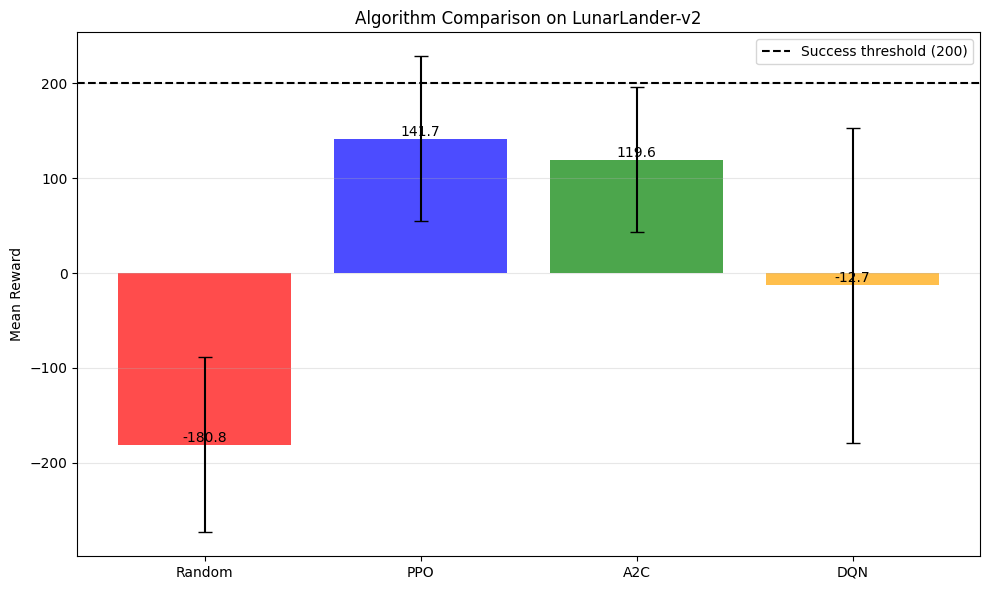


Observations:
  - PPO typically performs best (most reliable)
  - A2C learns faster but can be less stable
  - DQN is sample-efficient but sensitive to hyperparameters


In [22]:
# Compare all algorithms
algorithms = ['Random', 'PPO', 'A2C', 'DQN']
mean_rewards = [
    np.mean(random_rewards),
    mean_reward,
    mean_a2c,
    mean_dqn
]
std_rewards = [
    np.std(random_rewards),
    std_reward,
    std_a2c,
    std_dqn
]

# Plot comparison
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'orange']
bars = plt.bar(algorithms, mean_rewards, yerr=std_rewards, 
               capsize=5, color=colors, alpha=0.7)
plt.axhline(y=200, color='black', linestyle='--', label='Success threshold (200)')
plt.ylabel('Mean Reward')
plt.title('Algorithm Comparison on LunarLander-v2')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mean in zip(bars, mean_rewards):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{mean:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nObservations:")
print(f"  - PPO typically performs best (most reliable)")
print(f"  - A2C learns faster but can be less stable")
print(f"  - DQN is sample-efficient but sensitive to hyperparameters")

---

## Task 4: Hyperparameter Experiments

Now experiment with hyperparameters to see their effect!

**Your task:** Try different learning rates with PPO and observe the impact.

**What to adjust:**
- `learning_rate`: Higher = faster learning but less stable
- Try: `1e-4` (low), `3e-4` (default), `1e-3` (high)

Experimenting with learning rates...
(Training 3 agents with 50k steps each - takes ~5 min)

Training with LR=0.0001...
  Result: -793.97 ± 258.20

Training with LR=0.0003...
  Result: -547.01 ± 139.38

Training with LR=0.001...
  Result: -54.77 ± 54.61



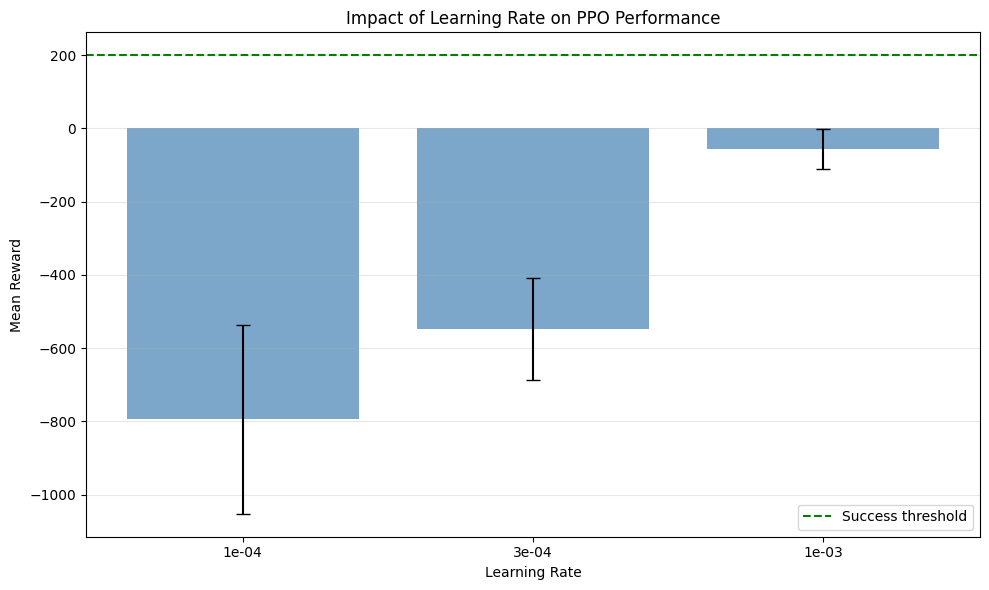


What did you observe?
  - Too low: Slow learning, might not solve in time
  - Default: Good balance
  - Too high: Might be unstable or overshoot


In [23]:
def train_and_evaluate(learning_rate, timesteps=50_000):
    """Train PPO with given learning rate and evaluate."""
    env = gym.make('LunarLander-v3')
    
    model = PPO(
        'MlpPolicy',
        env,
        learning_rate=learning_rate,
        verbose=0,  # Suppress output for cleaner comparison
        seed=42
    )
    
    model.learn(total_timesteps=timesteps)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
    
    return mean_reward, std_reward


# Experiment with different learning rates
learning_rates = [1e-4, 3e-4, 1e-3]
results = {}

print("Experimenting with learning rates...")
print("(Training 3 agents with 50k steps each - takes ~5 min)\n")

for lr in learning_rates:
    print(f"Training with LR={lr}...")
    mean, std = train_and_evaluate(lr, timesteps=50_000)
    results[lr] = (mean, std)
    print(f"  Result: {mean:.2f} ± {std:.2f}\n")

# Plot results
plt.figure(figsize=(10, 6))
lrs = [f"{lr:.0e}" for lr in learning_rates]
means = [results[lr][0] for lr in learning_rates]
stds = [results[lr][1] for lr in learning_rates]

plt.bar(lrs, means, yerr=stds, capsize=5, alpha=0.7, color='steelblue')
plt.axhline(y=200, color='g', linestyle='--', label='Success threshold')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Reward')
plt.title('Impact of Learning Rate on PPO Performance')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nWhat did you observe?")
print("  - Too low: Slow learning, might not solve in time")
print("  - Default: Good balance")
print("  - Too high: Might be unstable or overshoot")

---

## Task 5 (Optional): Training Longer

The previous experiments used 50k-100k steps for speed. But can we do better with more training?

**Your task:** Train PPO for longer (300k steps) and track learning progress.

In [ ]:
# Create evaluation callback to track progress
eval_env = gym.make('LunarLander-v3')
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/',
    log_path='./logs/',
    eval_freq=5000,  # Evaluate every 5k steps
    n_eval_episodes=20,
    deterministic=True,
    render=False
)

# Train for longer
env = gym.make('LunarLander-v3')
model_long = PPO('MlpPolicy', env, verbose=1, seed=42)

print("Training PPO for 300k steps...")
print("(This takes ~15 minutes)\n")

model_long.learn(total_timesteps=300_000, callback=eval_callback)

# Final evaluation
mean_long, std_long = evaluate_policy(model_long, env, n_eval_episodes=100)
print(f"\nFinal performance: {mean_long:.2f} ± {std_long:.2f}")

---

## Summary

### What You Learned

1. **Using RL libraries**: stable-baselines3 makes it easy to try different algorithms
2. **Algorithm comparison**: PPO is reliable, A2C is fast, DQN needs tuning
3. **Hyperparameter impact**: Learning rate significantly affects performance
4. **Training time**: More training usually helps, but with diminishing returns

### Key Takeaways

**What makes RL challenging:**
- Sparse rewards (only get signal at landing/crash)
- Delayed consequences (actions affect future states)
- High variance in training
- Sensitive to hyperparameters

**What helps:**
- Good algorithm choice (PPO is often best default)
- Sufficient training time
- Appropriate learning rate
- Multiple random seeds for robustness

### Things You Can Try

1. **Different environments**: Try `LunarLanderContinuous-v3` (continuous actions)
2. **Network architecture**: Modify `policy_kwargs` to use bigger networks
3. **Reward shaping**: Modify the environment to give better feedback
4. **Curriculum learning**: Start with easier tasks, gradually increase difficulty
5. **Ensemble methods**: Train multiple agents and combine their predictions

---

## What's Next?

You're now ready to work on your project! Choose from:
- Atari games (Pong, Breakout)
- Autonomous driving (Highway-Env)
- Stock trading (Financial RL)
- Multi-agent scenarios (PettingZoo)

Or propose your own project idea!